In [1]:
import seaborn as sns
import pandas as pd # pandas lib for DataFrames
import spacy #NLP
import re #регулярные выражение
import numpy as np #numpy arrays
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer= PorterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords #stopwords for NLP
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from sklearn.neighbors import NearestNeighbors #KNN model 
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from operator import itemgetter
from collections import OrderedDict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zewa2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dt_links=pd.read_csv("links.csv",encoding="utf-8")
dt_movies=pd.read_csv("movies.csv",encoding="utf-8")
dt_tags=pd.read_csv("tags.csv",encoding="utf-8")
dt_ratings=pd.read_csv("ratings.csv",encoding="utf-8")

## Загрузим наши данные и посмотрим на них

In [3]:
dt_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


А сколько всего пользовтелей в нашем датасете?

In [4]:
dt_ratings.groupby(['userId']).count()

,movieId,rating,timestamp
userId,,,
1,232,232,232
2,29,29,29
3,39,39,39
4,216,216,216
5,44,44,44
...,...,...,...
606,1115,1115,1115
607,187,187,187
608,831,831,831


In [5]:
dt_tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [6]:
dt_links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


dt_tags содержит в себе теги пользователей к фильмам, однако тегов там мало и так как нам дан dt_links оттуда мы можем получить более полную картину тегов, а понравился ли пользователю фильм легче сказать по dt_ratings.

In [7]:
dt_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## После беглого взгляда на данные появляется 2 идеи:
                 1) Простая модель где пользователи будут векторами в пространстве фильмов и в качестве рекомендации можно будет посмотреть на похожих друг с другом пользователей и предложить им те фильмы, которые смотрел похожий пользватель.
                 user-user similarity ( в качестве модели можно использовать KNN c метрикой cosine similarity )
                 2) Модель где где вектора фильмы понравившиеся пользователю, а координаты многочисленные параметры фильмов, который можно достать как из данных так и из сайта с помощью dt_links.
                 2* Идея : после получения набора фильмов которые понравились пользовтелям, кластеризовать их например на 2 кластера и искать ближайших соседей к центроидам соотвественных кластеров.
                 3) Как результат использовать фильмы полученые и user-user similarity и movie-movie similarity
                 
                 что можно еще сделать ?? подумать 
        

# Построим модель (1)
 для нее понадобятся только рейтинги , возможно теги можно будет добавить, но пока не будем

In [8]:
dt_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [9]:
dt_temp=dt_ratings.groupby(['movieId']).count()

то есть около 3000 фильмов мы знаем, что они оценивались только одним пользователем, то есть для этой модели это не даст нем ничеого  

In [10]:
dt_temp=dt_temp.loc[dt_temp['userId'] == 1]

Отлично, у нас данные ровно по фильмам, которые нам данных, значит путаницы не будет
хотя мы делали это для другой цели, но видно что многие фильмы оценили только один юзер из нашей выборки стоит ли удалить такие фильмы?? давайте попробуем

## Дальше будем строить датасет пользователей

In [11]:
dt_temp

,userId,rating,timestamp
movieId,,,
49,1,1,1
55,1,1,1
77,1,1,1
83,1,1,1
96,1,1,1
...,...,...,...
193581,1,1,1
193583,1,1,1
193585,1,1,1


In [12]:
dt_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [13]:
ratings_md1=dt_ratings

In [14]:
for i in (dt_temp.index):
    index = ratings_md1[ ratings_md1['movieId'] == i ].index
    ratings_md1.drop(index, inplace = True)

In [15]:
ratings_md1

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [16]:
(ratings_md1.groupby(['movieId']).count())

,userId,rating,timestamp
movieId,,,
1,215,215,215
2,110,110,110
3,52,52,52
4,7,7,7
5,49,49,49
...,...,...,...
187541,4,4,4
187593,12,12,12
187595,5,5,5


Теперь мы знаем какие фильмы посмотрели хотя бы 2 пользователя

In [17]:
ratings_md1['timestamp'].max()-ratings_md1['timestamp'].min()

709674635

In [18]:
(((709674635/60)/60)/24)/365

22.503635052004057

хмм тем самым между последний и первым ревью 22 года разница...

In [19]:
ratings_md1['timestamp'].mean()

1201593474.3061504

In [20]:
for i in range (1,610):
    print(((ratings_md1[ ratings_md1['userId'] ==  i  ]['timestamp'].std()/60)/60)/24)

0.561542033028967
0.0017251248674287373
0.0034037599403316555
229.05721430962635
0.0025893127381328112
0.011743205056989297
222.62373523169643
0.0018434649436229738
0.002551471938716023
0.5163244029377536
6.853258713266729
0.0051683695393252285
2.470708948284632
0.003931600144647479
792.8445363137411
0.005140794617258458
84.8326795176455
187.89272033762438
0.03045532930127709
0.4707680746689455
346.2178395474598
0.9276094423116215
1.8315935875762286
0.03907551233022965
0.00046593950548426253
0.001022866426176238
14.223045901226435
111.1593408014388
384.4313732970682
0.0004986910167882251
5.520535058142279
0.005236230869405799
1.4189522046740526
23.824376456944268
0.002750809962704218
0.002148274314858081
2.3936596174838813
0.002076461216918099
0.008957201395587193
0.004849843218763912
2.4774427307602775
0.22370598879233905
0.005259028904431886
44.91020805858781
710.3855850634062
0.0022282857318383768
0.024537957709238972
0.002330067821970993
0.015487843809348307
71.89497228569392
0.178

107.60894984972167
0.0020088975592877745
18.93703626424463
359.68679766579845
0.28689862443742337
0.01040825222445258
0.5273922588039863
0.00022248538009119322
666.1770420500612
0.0003024473274384584
91.66212765098265
0.0009881571923310393
1.7729444230563416
0.012492748021841624
0.0069359614437530725
0.00416116545551088
140.4975030983595
0.0010425759675160371
0.00196891368954273
9.898842698875876
0.0004651246286941322
440.60571780871715
37.256280195023905
0.0020131810765411763
0.0015934351090813395
0.006305547154193966
1916.3826278405556
0.006640405127977977
0.005350892803905326
0.7409292352609923
51.16165452128558
229.35336183705058
19.466391681269936
0.0022616979850907048
0.0012682560627271108
0.002301203082477112
0.006636327979192399
0.003960042262015178
0.007580276085101455
0.0010023546881206898
1468.4393872087494
0.0041208576745538975
216.56650860028844
0.003852633231529698
0.13998206648345765
0.007946201286234867
0.0005320200820985392
1.9215380213382425
2.8511143028122627
0.01521

но в общем для каждого пользователя отдельное отклоенение не велико
то есть на данные говорящие о моменте проставления отзыва можжно не смотреть

In [21]:
ratings_md1.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [22]:
def form_user_films_table(ratings_md1):
    """This function going to form table with rows for each user coressponding for viewed and rated films
        But if we already formed this table it will load it from csv file

    Args:
        param1 (DataFrame): DataFrame with ratings based on which function will form users table.

    Returns:
        DataFrame: Tabke with users and ratings for each viewed/rated film by user
    """
    try :
        users_films=pd.read_csv("users_films.csv",encoding="utf-8")
    except:
        movies_arr=ratings_md1['movieId'].unique()
        for i in range(1,611):
            users_films=pd.DataFrame(columns=ratings_md1['movieId'].unique())
            users_films.insert(0, "userId", [], True)
            temp_arr=np.zeros(6279, dtype=float)
            temp=ratings_md1[ ratings_md1['userId'] ==  i]
            temp_arr[0]=i
            for j in range(6278):
                temp_arr[j+1]=temp[temp['movieId']== movies_arr[j]]['rating'].sum()
            users_films=users_films.append(pd.DataFrame(temp_arr.reshape(1,-1), columns=list(users_films)), ignore_index=True)
        users_films=users_films.set_index('userId')
        users_films.to_csv("users_films.csv")
    return users_films

In [23]:
users_films=form_user_films_table(ratings_md1)

In [24]:
users_films.pop('userId')

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
       ...  
605    606.0
606    607.0
607    608.0
608    609.0
609    610.0
Name: userId, Length: 610, dtype: float64

Вот мы получили набор юзер-векторов в простом пространстве фильмов
теперь попробуем посмотреть что на скажет кнн 

In [25]:
user_knn = NearestNeighbors(n_neighbors=4, metric = 'cosine')
user_knn.fit(users_films)

NearestNeighbors(metric='cosine', n_neighbors=4)

датасет для первой модели готов

In [26]:
def get_soup(url):
    """ Function forming BeautifulSoup object for parsing data from site

    Args:
        url (str): url link on site .

    Returns:
        BeautifulSoup object:  BeautifulSoup object.


    """
    req = requests.get(url, headers={"User-Agent": random.choice(user_agent_list)}, proxies=proxies)
    return BeautifulSoup(req.text.encode(req.encoding), "html.parser")


In [27]:
p=np.zeros(14, dtype=object)
p[0]='movieId'
p[1]='ratingValue'
p[2]="ratingCount"
p[3]='summary_text'
p[4]='sometext'
p[5]='director'
p[6]='actor1'
p[7]='actor2'
p[8]='actor3'
p[9]='tag1'
p[10]='tag2'
p[11]='tag3'
p[12]='tag4'
p[13]='tag5'
"""list: set of list coresponding data for site to form DataFrame
"""

'list: set of list coresponding data for site to form DataFrame\n'

In [28]:
films_parsed=pd.DataFrame(columns=p)
"""DataFrame: DataFrame for collecting data from site
"""

'DataFrame: DataFrame for collecting data from site\n'

In [29]:
def parse_films_data_small(dt_links,films_parsed):
    start=time.time()
    base_url='https://www.imdb.com/title/tt0'
    for i in range(dt_links.shape[0]):
        p=np.zeros(14, dtype=object)
        p[0]=dt_links['movieId'].sum()
        added_part=str(dt_links['imdbId'][i].sum())
        url=base_url+added_part
        time.sleep(random.uniform(3, 6))
        sp=get_soup(url)
        p[1]=sp.find("span", itemprop="ratingValue").text.strip()
        p[2]=sp.find("span", itemprop="ratingCount").text.strip()
        p[3]=sp.find("div", class_="summary_text").text.strip()
        p[4]=sp.find("div", class_="subtext").text.strip()
        p[5]=sp.find("div", class_='credit_summary_item').find("a").text.strip()
        try:
            p[6]=sp.findAll("div",class_="credit_summary_item" )[0].findAll('a')[0].text.strip()
        except: 
            pass
        try:
            p[7]=sp.findAll("div",class_="credit_summary_item" )[1].findAll('a')[0].text.strip()
        except: 
            pass
        try:
            p[8]=sp.findAll("div",class_="credit_summary_item" )[2].findAll('a')[0].text.strip()
        except: 
            pass
        try:
            p[13]=sp.findAll("span", class_="itemprop")[4].text.strip()
        except: 
            pass
        try:
            p[9]=sp.findAll("span", class_="itemprop")[0].text.strip()
        except: 
            pass
        try:
            p[10]=sp.findAll("span", class_="itemprop")[1].text.strip()
        except: 
            pass
        try:
            p[11]=sp.findAll("span", class_="itemprop")[2].text.strip()
        except: 
            pass
        try:
            p[12]=sp.findAll("span", class_="itemprop")[3].text.strip()
        except: 
            pass
        films_parsed=films_parsed.append(pd.DataFrame(p.reshape(1,-1), columns=list(films_parsed)), ignore_index=True)
    print("--- %s seconds ---" % (time.time() - start))
    return films_parsed
    

## такой парсинг займет около 18-20 часов, давайте найдем api и подйдем этим путем

In [30]:
def parse_films_data_small(dt_links):
    """Function will use mdb free api to extend our films dataset with more features
        but if we already did this, function will just load table from our csv file

    Args:
        dt_links (DataFrame): table with links, so we can take id for each film.

    Returns:
        DataFrame: table with films and features for each film.

    """
    try :
        films_parsed=pd.read_csv('films_parsed.csv')
    except:
        p=np.zeros(19,dtype=object)
        p[0]='movieId'
        p[1]='adult'
        p[2]="overview"
        p[3]='popularity'
        p[4]='vote_average'
        p[5]='vote_count'
        p[6]='actor1'
        p[7]='actor2'
        p[8]='actor3'
        p[9]='tag1'
        p[10]='tag2'
        p[11]='tag3'
        p[12]='tag4'
        p[13]='tag5'
        p[14]='director'
        p[15]='similar1'
        p[16]='smilar2'
        p[17]='similar3'
        p[18]='similar4'
        films_parsed=pd.DataFrame(columns=p)
        start=time.time()
        base_url='https://api.themoviedb.org/3/movie/'
        key_part='?api_key=1ce37f178faf6f0d6e84a3cfcb381625'
        for i in range(dt_movies.shape[0]):
            p=np.zeros(19, dtype=object)
            p[0]=dt_links['movieId'][i].sum()
            movie_url=str(dt_links['tmdbId'][i].sum())
            res_m=requests.get(base_url+movie_url+key_part).json()
            res_c=requests.get(base_url+movie_url+'/credits'+key_part).json()
            res_k=requests.get(base_url+movie_url+'/keywords'+key_part).json()
            res_s=requests.get(base_url+movie_url+'/similar'+key_part).json()
            try :
                p[1]=res_m['adult']
            except:
                pass
            try :
                p[2]=res_m['overview']
            except:
                pass
            try :
                p[3]=res_m['popularity']
            except:
                pass
            try :
                p[4]=res_m['vote_average']
            except:
                pass
            try :
                p[5]=res_m['vote_count']
            except:
                pass
            try :
                p[6]=res_c['cast'][0]['name']
            except:
                pass
            try :
                p[7]=res_c['cast'][1]['name']
            except:
                pass
            try :
                p[8]=res_c['cast'][2]['name']
            except:
                pass
            try :
                p[9]=res_k['keywords'][0]['name']
            except:
                pass
            try :
                p[10]=res_k['keywords'][1]['name']
            except:
                pass
            try:
                p[11]=res_k['keywords'][2]['name']

            except: 
                pass
            try:
                p[12]=res_k['keywords'][3]['name']
            except: 
                pass
            try:
                p[13]=res_k['keywords'][4]['name']
            except: 
                pass
            directors=''
            try:
                for j in res_c['crew']:
                    if j['job']=='Director':
                           directors=directors+(j['name'])
            except:
                pass
            p[14]=directors
            try:
                p[15]=res_s['results'][0]['title']
            except: 
                pass
            try:
                p[16]=res_s['results'][1]['title']
            except: 
                pass
            try:
                p[17]=res_s['results'][2]['title']
            except: 
                pass
            try:
                p[18]=res_s['results'][3]['title']
            except: 
                pass
            films_parsed=films_parsed.append(pd.DataFrame(p.reshape(1,-1), columns=list(films_parsed)), ignore_index=True)
        print("--- %s seconds ---" % (time.time() - start))
        films_parsed.to_csv('films_parsed.csv')  
    return films_parsed
        

In [31]:
films_parsed=parse_films_data_small(dt_links)

In [32]:
films_parsed.pop('Unnamed: 0')

0          0
1          1
2          2
3          3
4          4
        ... 
9737    9737
9738    9738
9739    9739
9740    9740
9741    9741
Name: Unnamed: 0, Length: 9742, dtype: int64

In [33]:
films_parsed

,movieId,adult,overview,popularity,vote_average,vote_count,actor1,actor2,actor3,tag1,tag2,tag3,tag4,tag5,director,similar1,smilar2,similar3,similar4
0,411115845,False,"Led by Woody, Andy's toys live happily in his ...",98.094,7.9,13891,Tom Hanks,Tim Allen,Don Rickles,martial arts,jealousy,toy,friendship,bullying,John Lasseter,Kung Fu Panda 2,Madagascar: Escape 2 Africa,3 Ninjas Kick Back,Sex Drive
1,411115845,False,When siblings Judy and Peter discover an encha...,14.556,7.2,8130,Robin Williams,Jonathan Hyde,Kirsten Dunst,giant insect,board game,jungle,disappearance,recluse,Joe Johnston,Tarzan & Jane,Tarzan II,The Legend of Tarzan,Jumanji: Welcome to the Jungle
2,411115845,False,A family wedding reignites the ancient feud be...,10.656,6.5,242,Walter Matthau,Jack Lemmon,Ann-Margret Olsson,fishing,old man,best friend,duringcreditsstinger,0,Howard Deutch,"Love, Rosie",Friends with Kids,Three Steps Over Heaven,Sex Drive
3,411115845,False,"Cheated on, mistreated and stepped on, the wom...",7.773,6.4,91,Whitney Houston,Angela Bassett,Loretta Devine,based on novel or book,interracial relationship,single mother,divorce,chick flick,Forest Whitaker,Interview with the Vampire,The Muppet Christmas Carol,The Revenant,An Officer and a Spy
4,411115845,False,Just when George Banks has recovered from his ...,10.312,6.2,485,Steve Martin,Diane Keaton,Martin Short,parent child relationship,baby,midlife crisis,confidence,pregnancy,Charles Shyer,The Croods,Little Voice,Tully,Traffic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,411115845,False,"Ciel learns of a ""Aurora Society"", that is rum...",9.548,7.8,63,Daisuke Ono,Maaya Sakamoto,Yukari Tamura,anime,0,0,0,0,Noriyuki Abe,Dragon Ball Z: Cooler's Revenge,Dragon Ball Z: The World's Strongest,Dragon Ball Z: The Return of Cooler,Dragon Ball Z: Broly – The Legendary Super Saiyan
9738,411115845,False,"In ancient Disboard, Riku is an angry, young w...",38.541,7.9,235,Yoko Hikasa,Ai Kayano,Yoshitsugu Matsuoka,anti hero,magic,supernatural,end of the world,tragedy,Atsuko Ishizuka,Demon Slayer – Kimetsu no Yaiba – The Movie: M...,Trinity Seven 2: Heaven's Library & Crimson Lord,Re:ZERO -Starting Life in Another World- Memor...,A Whisker Away
9739,411115845,False,A woman deals with the toxic water scandal in ...,6.714,7.1,14,Queen Latifah,Betsy Brandt,Rob Morrow,0,0,0,0,0,Bruce Beresford,0,0,0,0
9740,411115845,False,A large scale catastrophe is occurring across ...,43.040,8.2,72,Kensho Ono,Mamoru Miyano,Kisho Taniyama,supernatural,mafia,super power,anime,0,Takuya Igarashi,My Hero Academia: Two Heroes,My Hero Academia: World Heroes' Mission,The Seven Deadly Sins: Prisoners of the Sky,My Hero Academia: Heroes Rising


In [34]:
len(films_parsed['tag3'].append(films_parsed['tag4']).append(films_parsed['tag1']).append(films_parsed['tag2']).unique())

5524

In [35]:
len(films_parsed['actor1'].append(films_parsed['actor2']).append(films_parsed['actor3']).unique())

10933

In [36]:
len(films_parsed['similar1'].append(films_parsed['smilar2']).append(films_parsed['similar3']).append(films_parsed['similar4']).unique())

5805

Теперь мы можем посмотерть насколько много разных признаковых данных в нашем датасете, чтобы понять из каких мы можем строить модель. Актеров как мы видим почти столько же, сколько и наших фильмов.

In [37]:
films_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       9742 non-null   int64  
 1   adult         9742 non-null   object 
 2   overview      9731 non-null   object 
 3   popularity    9742 non-null   float64
 4   vote_average  9742 non-null   float64
 5   vote_count    9742 non-null   int64  
 6   actor1        9742 non-null   object 
 7   actor2        9742 non-null   object 
 8   actor3        9742 non-null   object 
 9   tag1          9742 non-null   object 
 10  tag2          9742 non-null   object 
 11  tag3          9742 non-null   object 
 12  tag4          9742 non-null   object 
 13  tag5          9742 non-null   object 
 14  director      9626 non-null   object 
 15  similar1      9742 non-null   object 
 16  smilar2       9742 non-null   object 
 17  similar3      9742 non-null   object 
 18  similar4      9742 non-null 

у нас добавилось много данных по фильмам, чтобы попробовать строить векторное пространство 

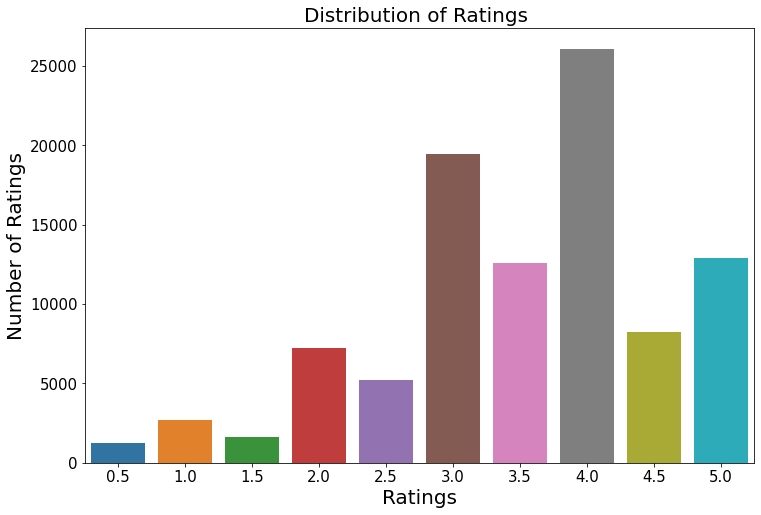

In [38]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=dt_ratings)


plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings ", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [39]:
no_of_rated_movies_per_user = dt_ratings.groupby(by = "userId")["rating"].count().sort_values(ascending = False)


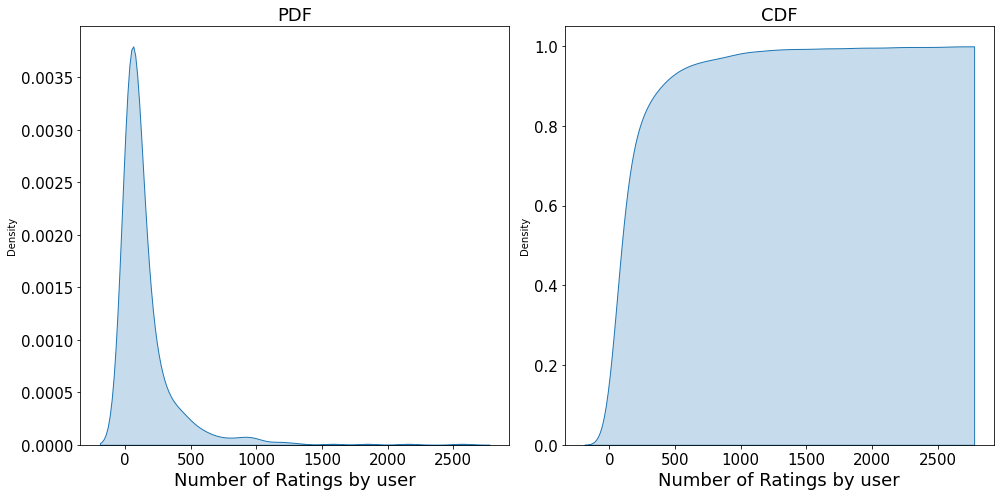

In [40]:

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

распределение отзывов от пользователей хорошее, по каждому есть какая то информация, при этом есть пользователи, котоыре посмотрели очнеь много фильмов.

In [41]:
users_films

,1,3,6,47,50,70,101,110,151,157,...,98499,98623,184,506,645,1612,2283,3655,4428,4690
0,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,3.0,4.5,4.0,0.0,3.5,0.0,4.0,...,0.0,0.0,0.0,4.0,4.0,3.0,3.0,3.5,2.5,3.5
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,2.5,2.0,0.0,4.5,4.5,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
def getAverageRatings(users_films, if_user):
    """Funtion calculating average rating by user or for film

    Args:
        users_films (DataFrame): Table with users and films they rated/viewed.
        if_user (bool): this telling us calculate for user/film.

    Returns:
        dict: Avarege rating for each movie or user.

    """

    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = users_films.sum(axis = ax).to_numpy() #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (users_films!=0).sum(axis = ax).to_numpy()  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = users_films.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [43]:
users_films['avg_rating']=getAverageRatings(users_films, True).values()

In [44]:
users_films.pop('avg_rating')

0      4.367965
1      3.910714
2      2.171429
3      3.556604
4      3.636364
         ...   
605    3.653495
606    3.783784
607    3.131356
608    3.277778
609    3.719298
Name: avg_rating, Length: 610, dtype: float64

Теперь давайте составим датасеты для обучения второй модели

In [45]:
def add_genres():
    """Funtion forming list with genres we have in our dataset

    Args:
        users_films (DataFrame): Table with users and films they rated/viewed.
        if_user (bool): this telling us calculate for user/film.

    Returns:
        dict: Avarege rating for each movie or user.

    """
    genres_map=[]
    for genres in dt_movies['genres']:
        for sing_genre in genres.split('|'):
            genres_map.append(sing_genre) 
    return genres_map

In [46]:
features = np.unique(add_genres())


In [47]:
films_vectors=pd.DataFrame(columns=features)

In [48]:
len(films_parsed['tag3'].append(films_parsed['tag4']).append(films_parsed['tag1']).append(films_parsed['tag2']).unique())
len(films_parsed['actor1'].append(films_parsed['actor2']).append(films_parsed['actor3']).unique())

10933

In [49]:
dt_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [50]:
def sentToWords(sentences):
    """ Function clears overwies of films iwth regular expressions

    Args:
        sentences (DataFrame): List with text with overwiew about films.

    Returns:
        list : cleaned texts which we can process in our model.
    """
    clean_texts= []
    for sent in sentences:
        clean = str(sent)
        clean = re.sub('\S*@\S*\s?', '', clean)  # remove emails
        clean = re.sub('\s+', ' ', clean)  # remove newline chars
        clean = re.sub("\'", "", clean)  # remove single quotes
        clean = clean.lower() #tolowercase
        clean = re.sub(r'\d+', '', clean) #remove numbers
        clean = clean.strip()
        #sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        clean_texts.append(clean)
    return clean_texts

In [51]:
data = films_parsed['overview'].values.tolist()

In [52]:
abit_clean = sentToWords(data)

In [53]:
def stemming(text):
    """ Function stems words in sentence

    Args:
        text (list): list of word used in sentence

    Returns:
        string : string sentence with processed stemming.
    """
    result=''
    text=word_tokenize(text)
    for word in text:
         result=result+' '+stemmer.stem(word)
    return result


In [54]:
stop_words.extend(['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'easi', 'easili', 'ha', 'hi', 'mani', 'might', 'must', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'tri', 'veri', 'wa', 'whi', 'wo', 'yourselv'])

In [55]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer= PorterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zewa2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
def tf_vectorizer(texts , stop_words_var,n = None):
    """ Function which for tf-idf vectotrs of descriptions

    Args:
        text (list): list of clean descriptions
        stop_words_var(list): lsit of stop words
        n(int) : max number of features
    Returns:
        DataFrame : vectorized films in terms rf-idf
     """
    tfidf=TfidfVectorizer(min_df = 4, max_df= 0.5 , ngram_range=(1,2), max_features= n , stop_words=stop_words_var ,preprocessor=stemming)
    features = tfidf.fit_transform(texts)
    lazy_train=pd.DataFrame(
        features.todense(),
        columns=tfidf.get_feature_names()
  )
    return lazy_train

In [57]:
films_lazy_vector=tf_vectorizer(abit_clean,stop_words)

C:\Users\zewa2\anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [58]:
films_lazy_vector

,aaron,abandon,abbi,abbott,abduct,abe,abid,abil,abil commun,abl,...,zealand,zealot,zebra,zero,zeu,zoe,zombi,zone,zoo,zoologist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
films_lazy_vector_knn = NearestNeighbors(n_neighbors=3, metric='cosine')
films_lazy_vector_knn.fit(films_lazy_vector)

NearestNeighbors(metric='cosine', n_neighbors=3)

Модель 2(а) построена, давайте отдельно добавим еще модель, где будем сранвивать фильмы по жанрам и тегам, а не только по описанию.

In [60]:
genres_map=[]
for genres in dt_movies['genres']:
    for sing_genre in genres.split('|'):
        genres_map.append(sing_genre) 

In [61]:
films_vectors=pd.DataFrame(columns=np.unique(np.array(genres_map)))

In [62]:
for tag in films_parsed['tag3'].append(films_parsed['tag4']).append(films_parsed['tag1']).append(films_parsed['tag2']).unique():
    films_vectors[tag]=''

In [63]:
films_vectors = pd.DataFrame(0, index=np.arange(films_parsed.shape[0]), columns=films_vectors.columns)

In [64]:
for i in range(films_parsed.shape[0]):
    for genre in dt_movies['genres'][i].split('|'):
            films_vectors[genre][i]=1
    films_vectors[films_parsed['tag1'][i]][i]=1
    films_vectors[films_parsed['tag3'][i]][i]=1
    films_vectors[films_parsed['tag2'][i]][i]=1
    films_vectors[films_parsed['tag4'][i]][i]=1

In [65]:
films_vectors

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,sea adventure,installation,narcism,lego,art installation,ferris wheel,halloween party,disorientation,die hard scenario,mister rogers
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
films_vector_knn = NearestNeighbors(n_neighbors=5, metric='cosine')
films_vector_knn.fit(films_vectors)

NearestNeighbors(metric='cosine')

In [67]:
vectors_with_text_tags = pd.concat([films_vectors,films_lazy_vector], axis=1)


Смешать эти параметры не получилось , не хватило опертивной памяти

In [68]:
def userRecomend(k):
    """function finding favorite films viewed by user:

    Args:
        k (int): id of our user.
    Returns:
        list : favorites films of user represented with id's on our system 0-9791

    """
    user_films_k=users_films.T[k].to_dict()
    fav_films=[]
    for i in user_films_k.keys():
        if user_films_k[i] > 3:
            fav_films.append((dt_links['movieId']==float(i)).argmax())
    return fav_films
    

In [69]:
def simmilar_to_films(array, films_vectos_tags = True):
    """function films to recommend to user based on film-film similarity:

    Args:
        array(list): list of favorites films of user.
        films_vectos_tags(bool): if true calculate films to recommend based on vectors with tags and genres 
                                    else based on descriptions of films
    Returns:
        list : films to recommend to user represented with id's on our system 0-9791

    """
    films_to_recommend=[]
    if films_vectos_tags :
        temp_films=films_vectors.loc[array]
        #тут т.к. мы хотим посмтроеть на похожие на любимые фильмы юзеры поработаем в предположении, что 
        # ему нравятся разные фильмы, то есть покластеризуем еву любимые фильм, если он смотрит только один жанр, это не должно
        # испортить картину, но должно улутьшить если смотри разные
        kmeans = KMeans(n_clusters=3, random_state=0).fit(films_vectors.loc[array]) 
        films_to_recommend.append(films_vector_knn.kneighbors([kmeans.cluster_centers_[0]])[1][0])
        films_to_recommend.append(films_vector_knn.kneighbors([kmeans.cluster_centers_[1]])[1][0])
        films_to_recommend.append(films_vector_knn.kneighbors([kmeans.cluster_centers_[2]])[1][0])
    else :
        temp_films=films_lazy_vector.loc[array]
        kmeans = KMeans(n_clusters=3, random_state=0).fit(films_lazy_vector.loc[array])
        films_to_recommend.append(films_lazy_vector_knn.kneighbors([kmeans.cluster_centers_[0]])[1][0])
        films_to_recommend.append(films_lazy_vector_knn.kneighbors([kmeans.cluster_centers_[1]])[1][0])
        films_to_recommend.append(films_lazy_vector_knn.kneighbors([kmeans.cluster_centers_[2]])[1][0])
    return films_to_recommend
    

In [70]:
def similar_to_user(k):
    """function films to recommend to user based on user-user similarity:

    Args:
        k: id of user in our system 1-610.
    Returns:
        list : films to recommend to user represented with id's on our system 0-9791

    """
    films_to_recomend=[]
    temp_users=user_knn.kneighbors([users_films.T[k]])[1]
    similar_users=np.delete(temp_users, np.where(temp_users == k))
    for user in similar_users:
        k=0
        for i in users_films.columns:
            if (users_films.T[k][i] == 0) and (users_films.T[user][i]>4) and (k < 5):
                films_to_recomend.append(dt_movies[dt_movies['movieId']==int(i)].index[0])
                k=k+1
    return films_to_recomend 
    

In [71]:
def viewedb_by_user(k):
    """function calculates films viewd by user k

    Args:
        k: id of user in our system 1-610.
    Returns:
        list : films viewed by user represented with id's on our system 0-9791
    """
    films_viewed=[]
    for i in users_films.columns:
        if users_films.T[k][i] > 0:
            films_viewed.append(dt_movies[dt_movies['movieId']==int(i)].index[0])
    return films_viewed

In [72]:
def sort_films_by_rating(array):
    """function calculates dictionary sorted by average rating in imdb system

    Args:
        array(list): list of films represented with id's on our system 0-9791.
    Returns:
        dict : sorted dict of films
    """
    dict_={}
    for ind in array :
        dict_[ind]=films_parsed['vote_average'][ind]
    dict_ = OrderedDict(sorted(dict_.items(), key=itemgetter(1),reverse = True))
    return dict_
        

In [73]:
def Recomend_films_for_user_k(k):
    """function of our model inside calculating all recomended films by all the models and showing 
        these films sorted by their ratings

    Args:
        k(int): id of user in our system 0-610.
    Returns:
        list : 10 best films to recommend to our user , ids of films in our system 0-9791
    """
    recomend_films=[]
    recomend_films=simmilar_to_films(userRecomend(k))  ## Найдем похожие фильмы по тегам и жанрам 
    recomend_films=recomend_films+(simmilar_to_films(userRecomend(k),False))  ## Найдем похожие фильмы по описанию
    recomend_films.append(similar_to_user(k)) ## Найдем похожие фильмы по тому какие фильмы нравятся похожим пользователям
    dict_={}
    print(recomend_films)
    for film in recomend_films:
        for j in film:
            try :
                dict_[j]=dict_[j]+1
            except:
                dict_[j]=1
    for film in viewedb_by_user(k):
        try:
            dict_.pop(film)
        except:
            pass
    dict_ = OrderedDict(sorted(dict_.items(), key=itemgetter(1),reverse = True)) ## отсортируем оставшиеся (которые наш пользватель
                                                                            ## не видел) по рейтингу
    recomend_films=[]
    film=[]
    p=10
    to_delete=[]
    for i in dict_:
        if dict_[i] > 1 :   ## выдадим ему те которые предожили нескоько моделей наверняка
            recomend_films.append(i)
            p=p-1
        else :
            film.append(i)
    films=sort_films_by_rating(film) 
    for film in films:
        recomend_films.append(film)
        p=p-1
        if p == 0:
            return recomend_films                                       ## выдадим ему 10 лучших
    return recomend_films

In [74]:
def showTitles(arr):
    """function showing titles of films 

    Args:
        arr(list): id of films in our system 0-9791.
    Returns:
        list : titles of these films
    """
    for i in arr:
            print(dt_movies['title'][i])

In [75]:
def favorites_by_user(k):
    """function calculate and showing favourite films for user k 

    Args:
        k(int): id of films in our system 0-9791.
    Returns:
        none : print titles of films
    """
    films_viewed=[]
    avg = getAverageRatings(users_films, True)[k]+0.3
    for i in users_films.columns:
        if users_films.T[k][i] > avg:
            films_viewed.append(dt_movies[dt_movies['movieId']==int(i)].index[0])
    showTitles(films_viewed)

## Теперь попробуем что у нас получилось

In [76]:
favorites_by_user(543)

Twister (1996)
Independence Day (a.k.a. ID4) (1996)
That Thing You Do! (1996)
Mr. Holland's Opus (1995)
William Shakespeare's Romeo + Juliet (1996)
Star Trek: First Contact (1996)
Long Kiss Goodnight, The (1996)
Children of the Corn IV: The Gathering (1996)
French Twist (Gazon maudit) (1995)
Anne Frank Remembered (1995)
Ed (1996)
Cry, the Beloved Country (1995)
Moll Flanders (1996)


In [77]:
showTitles(Recomend_films_for_user_k(543))

[array([  60,  530,  842,  101, 5590], dtype=int64), array([9246, 3741,  615, 1044,   84], dtype=int64), array([9298, 4097, 8649, 4894, 3875], dtype=int64), array([546,  84, 797], dtype=int64), array([ 55, 568, 800], dtype=int64), array([809, 548, 101], dtype=int64), [33, 55, 13, 77, 138, 630, 839, 1044]]
The Fool (2014)
Passion of Anna, The (Passion, En) (1969)
Dead Man Walking (1995)
Die Hard: With a Vengeance (1995)
The Emperor's Club (2002)
Top Gun (1986)
Karate Bullfighter (1975)
Sunshine State (2002)
White Squall (1996)
Phenomenon (1996)


In [78]:
viewedb_by_user(543)

[0,
 2,
 546,
 594,
 615,
 797,
 31,
 55,
 84,
 568,
 651,
 809,
 1044,
 800,
 842,
 13,
 60,
 101,
 530,
 36,
 548]

саня это демка не суди строго , понимаю там много тонких моментов типа в эти все функции надо будет добавить параметры типа юзер-юзер как далеко кнн фильм-фильм тоже самое там ща это как не параметры забито( 